In [1]:
import examples.rabi_driving.setup as rabi_setup
from qsim.simulator import Simulator
from qsim.optimize import LeastSquaresOptimizer

import numpy as np

# boundaries of the optimization:

# The maximal driving amplitudes is restricted by the maximal rabi 
# frequency of 1Mhz
amp_bound = rabi_setup.rabi_frequency_max * 2 * np.pi / rabi_setup.lin_freq_rel

# The phase can be chosen between 0 and 100 degree
phase_bound_upper = rabi_setup.phase_max / 180 * np.pi
phase_bound_lower = 0

upper_bounds = np.concatenate(
    (amp_bound * np.ones(rabi_setup.n_time_samples),
     phase_bound_upper * np.ones(rabi_setup.n_time_samples))
)

lower_bounds = np.zeros_like(upper_bounds)

bounds_phase_control = [lower_bounds, upper_bounds]


def random_phase_control_pulse(n):
    """Creates a random control sequence. """
    amp = amp_bound * np.random.rand(n)
    phase = (phase_bound_upper - phase_bound_lower) * np.random.rand(n) 
    return np.concatenate(
        (np.expand_dims(amp, 1), np.expand_dims(phase, 1)), axis=1)


termination_conditions_phase_control = {
    "min_gradient_norm": 1e-15,
    "min_cost_gain": 1e-15,
    "max_wall_time": 30.0,
    "max_cost_func_calls": 1e6,
    "max_iterations": 100,
    "min_amplitude_change": 1e-8
}

# The dynamics class has references to the simulation code and the cost 
# functions which shall be minimized.
dynamics_phase_control = Simulator(
    solvers=[rabi_setup.time_slot_comp_unperturbed_phase_control,
             rabi_setup.time_slot_comp_qs_noise_phase_control],
    cost_fktns=[rabi_setup.entanglement_infid_phase_control,
                rabi_setup.entanglement_infid_qs_noise_phase_control],
    cost_fktn_weights=[1, 1e2]
)

# The optimizer is essentially the least squares optimizer of the scipy
# package.
optimizer_phase_control = LeastSquaresOptimizer(
    system_simulator=dynamics_phase_control,
    termination_cond=termination_conditions_phase_control, 
    save_intermediary_steps=True, 
    method='trf', 
    bounds=bounds_phase_control, 
    use_jacobian_function=True
)


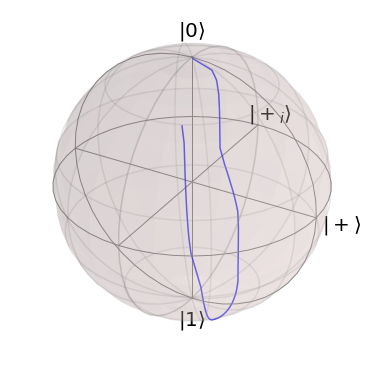

In [3]:
# we use and arbitrary pulse as starting point for the optimization.
np.random.seed(1)
initial_pulse = random_phase_control_pulse(rabi_setup.n_time_samples)

# Then we run the numerical optimization
result = (optimizer_phase_control.run_optimization(
    initial_control_amplitudes=initial_pulse))

# And plot the resulting dynamics on the bloch sphere
dynamics_phase_control.solvers[0].plot_bloch_sphere()


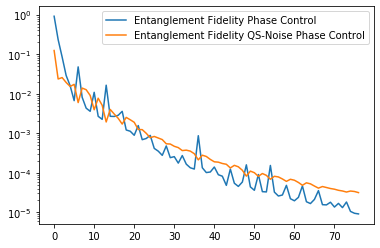

In [4]:
from qsim.data_container import DataContainer
from qsim.analyser import Analyser

# The data container can be used to store the optimization results.
storage_path = r"C:\teske\SimulationData\RabiDriving\PhaseControl"
file_name = r"test_run_1"

data_container = DataContainer(storage_path=storage_path, file_name=file_name)
data_container.append_optim_result(result)

# The Analyser class can be used visualize the optimization.
# Here we plot the cost functions in each time step.
analyser = Analyser(data=data_container)
analyser.plot_costs()

In [5]:
# the result class saves the relevant results of the optimization
result.to_dict()

{'final_cost': array([9.10942239e-06, 3.15358502e-05]),
 'indices': ['Entanglement Fidelity Phase Control',
  'Entanglement Fidelity QS-Noise Phase Control'],
 'final_amps': array([[0.45504732, 1.33953164],
        [0.81360884, 1.16195762],
        [1.25245556, 0.44689701],
        [0.97326968, 0.64162666],
        [1.78035406, 0.15581085],
        [1.36471396, 0.51978997],
        [1.18219818, 0.46296421],
        [1.02383795, 0.64967215],
        [0.61620795, 0.76927079],
        [0.60003609, 1.37600056]]),
 'final_grad_norm': 0.4886011685605697,
 'init_parameters': None,
 'num_iter': 77,
 'termination_reason': 'Maximum Wall Time Exceeded',
 'optimizer': <qsim.optimize.LeastSquaresOptimizer at 0x25a1bf53308>,
 'optimization_stats': <qsim.performance_statistics.PerformanceStatistics at 0x25a1bf53348>,
 'optim_summary': <qsim.optimization_data.OptimizationSummary at 0x25a22ae8248>}

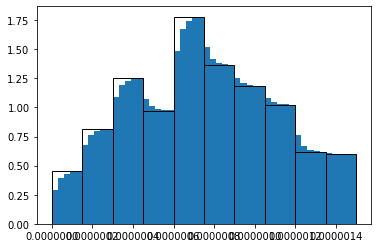

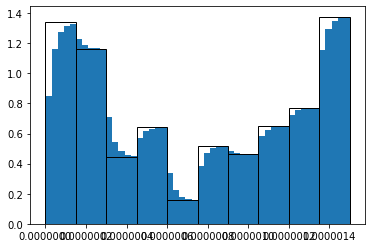

In [8]:
# Plot of the final control pulse

# The black transparent bars depict the implemented ideal pulse,
# while the blue solid bars show the pulses perceived by the qubit.

# The physical pulses have been calculated by the transfer function 
# which models an exponential saturation in the control electronics.
dynamics_phase_control.solvers[0].transfer_function.plot_pulse(
    result.final_parameters)
